In [1]:
import pandas as pd 
import numpy as np 
import spacy

from spacy.tokens import Doc, DocBin
from spacy.matcher import PhraseMatcher
from spacy import displacy

from tqdm.notebook import tqdm
from collections import Counter, defaultdict
import pickle
from pathlib import Path
import random
from joblib import Parallel, delayed

from collections import Counter
import phonetics 


from itertools import islice
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

Doc.set_extension("pdf_path", default=None)


spacy.__version__

'3.1.1'

In [2]:
# The documents saved in a previous notebook 

#!  python -m spacy download en_core_web_sm
model = "en_core_web_lg"

text_path  = Path('texts.pkl')
docs_path  = Path(f'docs-{model}.spacy')
nlp_path = Path(f'nlp-{model}.spacy')

nlp = spacy.load(model)
nlp.max_length = 3000000

nlp = nlp.from_disk(nlp_path)
doc_bin = DocBin().from_disk(docs_path)
docs = list(doc_bin.get_docs(nlp.vocab))

In [3]:
# Map of types of entities. 
import re
p = re.compile(r'\W+')

docv = list(docs)

wd = defaultdict(list)

for d in docv:
    for e in  d.ents:
        if not str(e).isnumeric():
            wd[e.label_].append(p.sub(' ', str(e.lemma_)).lower() )

cd = defaultdict(Counter)

for k, v in wd.items():
    cd[k].update(v)


In [4]:
%%time
# Make a single combined document
from spacy.tokens import Doc
cdocs = Doc.from_docs(docv)

<timed exec>:3: UserWarning: [W101] Skipping Doc custom extension 'pdf_path' while merging docs.


CPU times: user 34.8 s, sys: 3.06 s, total: 37.9 s
Wall time: 38 s


In [5]:
agrmt = pd.read_csv('agreement_statements.csv').iloc[:,1:]
agrmt.head()

,type,contractor,text,hash,path
0,contract,Alpha Project,"This agreement (""Agreement"") is made and enter...",469993d856132848e5ad869941392ed13cbf6c17297a18...,/Users/eric/proj/data-projects/text-classifica...
1,contract,Nami,"This agreement (""Agreement"") is made and enter...",6676b44941458a4809511372282f59e46080ebacd87911...,/Users/eric/proj/data-projects/text-classifica...
2,contract,NaN,"This Agreement (""AgreemenC') is made and enter...",43d2490bda4f4203580b70f41bcc32b1b9be419a91b34c...,/Users/eric/proj/data-projects/text-classifica...
3,indemnification,Mcalister Institute,"This indemnification agreement (""Agreement"") i...",46e4bfeaa01c20f6e5d240872ade6464f69f331610fd55...,/Users/eric/proj/data-projects/text-classifica...
4,contract,Deaf Community Services Of San Diego,"This agreement (""Agreement"") is made and enter...",5bcf9f12da1486f1c934dea3236b0bba80fc0e80551757...,/Users/eric/proj/data-projects/text-classifica...


In [6]:
types = agrmt[agrmt.type=='contract'][['type','contractor','path']].drop_duplicates()

In [7]:
%%time
# Create a full entities dataset
rows = []
ents = cdocs.ents
for doc in docs:
    for ent in doc.ents:
        p = tuple(t.lemma_.lower() for t in list(ent) if  t.is_alpha and not t.is_stop)
        if p:
            rows.append({'label': ent.label_,
                         'pstr': ' '.join(p), 
                         'p': p, 
                         'plen': len(p), 
                         'ent': ent, 
                         'sentence': ent.sent,
                         'path': doc._.pdf_path
                        })
    
ent_df = pd.DataFrame(rows)
#t['sentence']  = t.sentence.str.replace('\n',' ')

ent_df.head()


CPU times: user 12.7 s, sys: 165 ms, total: 12.8 s
Wall time: 12.9 s


,label,pstr,p,plen,ent,sentence,path
0,GPE,county san diego,"(county, san, diego)",3,"(the, County, of, San, Diego)","(This, agreement, (, "", Agreement, "", ), is, m...",/Users/eric/proj/data-projects/text-classifica...
1,GPE,state california,"(state, california)",2,"(the, State, of, California)","(This, agreement, (, "", Agreement, "", ), is, m...",/Users/eric/proj/data-projects/text-classifica...
2,ORG,alpha project,"(alpha, project)",2,"(Alpha, Project)","(This, agreement, (, "", Agreement, "", ), is, m...",/Users/eric/proj/data-projects/text-classifica...
3,NORP,homeless,"(homeless,)",1,(Homeless),"(This, agreement, (, "", Agreement, "", ), is, m...",/Users/eric/proj/data-projects/text-classifica...
4,FAC,avenue,"(avenue,)",1,"(3737, 5th, Avenue)","(This, agreement, (, "", Agreement, "", ), is, m...",/Users/eric/proj/data-projects/text-classifica...


In [8]:
s = ent_df[ent_df.label == 'MONEY'].copy()

t = s.sentence.astype(str).str.extract('\$([\d,]+)')
s['dvalue'] =  pd.to_numeric( t[0].str.replace(',',''))

s['text'] = s.sentence.astype(str).replace('\n','')

s = s.merge(agrmt[['path','type','contractor']])

In [9]:
s.head().T

,0,1,2,3,4
label,MONEY,MONEY,MONEY,MONEY,MONEY
pstr,thousand dollar,thirty thousand dollar,thousand dollar,thousand dollar,thousand dollar
p,"(thousand, dollar)","(thirty, thousand, dollar)","(thousand, dollar)","(thousand, dollar)","(thousand, dollar)"
plen,2,3,2,2,2
ent,"(fifty, thousand, dollars)","(Thirty, Thousand, Dollars)","(One, Hundred, Twenty, Thousand, Dollars)","(One, Hundred, Thousand, Dollars)","(Two, Hundred, Fifty, Thousand, Dollars)"
sentence,"(\n, Any, subcontract, or, consultant, agreeme...","(Pursuant, to, Exhibit, C, or, other, applicab...","(Pursuant, to, Exhibit, C, or, other, applicab...","(Pursuant, to, Exhibit, C, or, other, applicab...","(Pursuant, to, Exhibit, C, or, other, applicab..."
path,/Users/eric/proj/data-projects/text-classifica...,/Users/eric/proj/data-projects/text-classifica...,/Users/eric/proj/data-projects/text-classifica...,/Users/eric/proj/data-projects/text-classifica...,/Users/eric/proj/data-projects/text-classifica...
dvalue,50000.0,30000.0,30000.0,30000.0,30000.0
text,\nAny subcontract or consultant agreement that...,Pursuant to Exhibit C or other applicable pric...,Pursuant to Exhibit C or other applicable pric...,Pursuant to Exhibit C or other applicable pric...,Pursuant to Exhibit C or other applicable pric...
type,contract,contract,contract,contract,contract


In [10]:
mny = s[['dvalue','contractor','text','path']].drop_duplicates().copy()
mny['text'] = mny.text.str.replace('\n',' ').str.replace(',',' ').str.strip()

import re, string
# Filter out non printable
def filter_non_printable(str):
  return ''.join([c for c in str if ord(c) > 31 or ord(c) == 9])

mny['text'] = mny.text.apply(lambda v: filter_non_printable(v) )


mny.to_csv('money.csv', index=False)

In [11]:
mny

,dvalue,contractor,text,path
0,50000.0,Alpha Project,Any subcontract or consultant agreement that i...,/Users/eric/proj/data-projects/text-classifica...
1,30000.0,Alpha Project,Pursuant to Exhibit C or other applicable pric...,/Users/eric/proj/data-projects/text-classifica...
5,50000.0,Nami,Any subcontract or consultant agreement that i...,/Users/eric/proj/data-projects/text-classifica...
6,283320.0,Nami,Pursuant to Exhibit C County agrees to pay Co...,/Users/eric/proj/data-projects/text-classifica...
7,NaN,Nami,This Lease Amendment dated June 20 2016 for ...,/Users/eric/proj/data-projects/text-classifica...
...,...,...,...,...
2749,NaN,Neighborhood House Association,$ $ Page 96 of 156 County of San Diego - He...,/Users/eric/proj/data-projects/text-classifica...
2750,NaN,Neighborhood House Association,jTotal Amount 200 $ Page 172 County of San D...,/Users/eric/proj/data-projects/text-classifica...
2751,NaN,Neighborhood House Association,I ' Total Amount 10 000 $ Total Amount $ ...,/Users/eric/proj/data-projects/text-classifica...
2752,50000.0,Public Consulting Group,Services Template Page 1 of 24 rev 3/1/2018 ...,/Users/eric/proj/data-projects/text-classifica...


In [12]:
# Look for Exhibit C, Payment Schedul. 
import hashlib 

phrases = """
Pursuant to Exhibit C
"""

phrase_matcher = PhraseMatcher(nlp.vocab)
phrases = [ e for e in phrases.splitlines() if e ]
patterns = [nlp(text) for text in phrases]
phrase_matcher.add('agreement', None, *patterns)

agr_matches = {}

for doc in tqdm(list(docs)):

    for match_id, start, end in phrase_matcher(doc):
        span = doc[start:end]
        h = hashlib.sha224(str(span.sent).encode('utf8')).hexdigest()
        agr_matches[(id(doc), h)] = span.sent

print( f" {len(agr_matches)} Matches ")

mm = {}
misses = {}

from itertools import islice 
rows = []
for k, s in agr_matches.items():
    rows.append({
        'text': str(s), 
        'path': s.doc._.pdf_path,
    })
    
exc = pd.DataFrame(rows)
exc.head()
exc['text'] = exc.text.str.replace('\n',' ').str.replace(',',' ').str.strip()   

exc = exc.merge(agrmt[['path','contractor']])

exc = exc[['contractor','text','path']].copy().dropna(subset=['contractor'])

model = "en_core_web_lg"
nlp = spacy.load(model)

import re

def clean_money(t):
    
    return re.sub(r'(\d)\s+(\d)', r'\1,\2', t)


def ml_strip(t):

    t = t.replace('$', '').replace(',','')
    try:
        return float(t)
    except ValueError:
        return None

def money_list(t):
    t = clean_money(t)
    
    # Before and After the "MVA" statement
    try:
        (b,a) = t.lower().split('maximum agreement amount')
    except ValueError:
        (b,a) = t, ''
    
    b = list(set([ ml_strip(e.text) for e in nlp(b).ents if e.label_ == "MONEY"]))
    a = list(set([ ml_strip(e.text) for e in nlp(a).ents if e.label_ == "MONEY"]))
    
    if len(a) == 1:
        a = a[0]
    elif len(a) == 0:
        a = None
    
    return pd.Series([b, a], index=['ml','maa'])
    
exc = pd.concat( [exc,exc.text.apply(money_list)], axis=1)

exc=exc[exc.columns[[0,3,4,1,2]]]

exc['ml_sum'] = exc.ml.apply(lambda v: pd.Series(v, dtype='float64').sum())
exc['contract_value'] = exc.maa.where(~exc.maa.isnull(), other=exc.ml_sum)
exc = exc.drop_duplicates(subset=['path'])

exc.to_csv('exhibitc.csv')

exc.head()

  0%|          | 0/876 [00:00<?, ?it/s]

 135 Matches 


,contractor,ml,maa,text,path,ml_sum,contract_value
0,Alpha Project,"[30000.0, None, 100000.0, 120000.0]",250000.0,Pursuant to Exhibit C or other applicable pric...,/Users/eric/proj/data-projects/text-classifica...,250000.0,250000.0
1,Nami,[283320.0],1416600.0,Pursuant to Exhibit C County agrees to pay Co...,/Users/eric/proj/data-projects/text-classifica...,283320.0,1416600.0
3,Mcalister Institute,[586425.0],NaN,Pursuant to Exhibit C County agrees to pay Co...,/Users/eric/proj/data-projects/text-classifica...,586425.0,586425.0
4,Deaf Community Services Of San Diego,[],1495388.0,Pursuant to Exhibit C or other applicable pric...,/Users/eric/proj/data-projects/text-classifica...,0.0,1495388.0
5,Community Research Foundation,[1100000.0],5500000.0,Pursuant to Exhibit C County agrees to pay Co...,/Users/eric/proj/data-projects/text-classifica...,1100000.0,5500000.0


<AxesSubplot:>

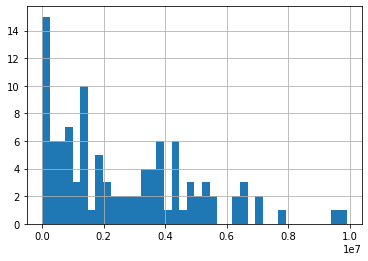

In [13]:
exc[exc.contract_value < 1e7].contract_value.hist(bins=40)